<a href="https://colab.research.google.com/github/danielleitesoares/Work_Sentimental_Analyzer_Of_Restaurant_Issue/blob/main/Analise_dos_Sentimentos_Restaurantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Analise de Sentimentos Restaurantes**
> Equipe: Leonardo Rocha, Paulo Correa e Daniel Soares
> Turma 02





### **0.Importação das Bibliotecas Utilizadas**




In [ ]:
# coding = utf-8  
#Bibliotecas Básicas
!pip install sweetviz 
import sweetviz
import pandas as pd
import numpy as np
import json
import nltk
nltk.download('punkt')
from textblob import TextBlob
import time  # avaliar
import sys
import unicodedata
import requests
#Bibliotecas de Gráficos e Relatórios 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas_profiling as ppf
from pandas_profiling import ProfileReport
import sweetviz as sv
from IPython.display import Image
from bs4 import BeautifulSoup
import re
!pip install sweetviz -q
!pip install -U pandas-profiling
!pip install --user -q datascience
!pip install --user -q pandas-profiling  
#Bibliotecas de Análise de Sentimentos
import textblob


### **1.Tratamento do dataset-v2.dat**

##### 1.1. Abrindo o Dataset 

In [ ]:

! git clone https://github.com/paulordie/sentimental_ds
%cd sentimental_ds/

##### 1.2 Abrindo e mostrando o Dataset do arquivo .dat


In [4]:
dados = open('dataset-v2.dat')
a = dados.readlines()# Criar uma lista com todos as linhas em strings 
v = [] # vetor para salvar cada linha em json  
#Comando for para correr por cada item de "a" que está as linhas 
for c in a:
  parsed_c = json.loads(c) #Traransformar as strings de "a" em arquivos json
  data = pd.json_normalize(parsed_c) #Normalizando o arquivo json 
  v.append(data)#jogamos os arquivos em 'V', 
  #aqui vamos concatenar cada linha que está em 'V' para um unico dataset df 
df = pd.concat(objs=v,axis=0) # Concatenando 

##### 1.3 Salvando em outros formatos

In [ ]:
#Montando o local no google drive pra salvar
import pandas as pd
from google.colab import drive
drive.mount("/content/drive")
#Converterndo e Salvando em CSV
df.to_csv('/content/drive/My Drive/dataset123.csv')#salvando o arquivo em csv  \\\\\\\\\\\\\\\\\\\\\verificar
#Convertendo e salvar em excel 
df.to_excel('/content/drive/My Drive/dataset.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### 1.4 Exibindo o Head do dataset

In [54]:
df = df.rename(columns={'itemReviewed.name':'Name','itemReviewed.address.streetAddress':'StressAddress','itemReviewed.address.addressLocality':'AddressLocality','itemReviewed.address.addressRegion':'AddressRegion','itemReviewed.address.postalCode':'PostalCode','itemReviewed.address.country':'Country','itemReviewed.website':'Website','itemReviewed.email':'Email','itemReviewed.phoneNumber':'PhoneNumber','itemReviewed.averageRating':'AverageRating'})
df = df.reset_index(drop=True)
df.head(10)

,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,Name,StressAddress,AddressLocality,AddressRegion,PostalCode,Country,Website,Email,PhoneNumber,AverageRating
0,Jantar,692856288,2344932,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,Imperador dos Camarões,Avenida Doutor Antônio Gouveia,,Alagoas,57030-170,Brasil,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5
1,Uma boa experiência.,229208487,3720906,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,Guacamole Natal,Avenida Praia de Ponta Negra 9068 Ponta Negra,,Rio Grande do Norte,59092-100,Brasil,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5
2,Otimo self service,679002332,2248105,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,Chica Pitanga,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,Sorvetes Vi Sabor,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,,Brasil,None,None,None,4.0
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,Z Deli Sandwich Shop,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5
5,Um achado maravilhoso!,482361860,12209902,Monique C,"O restaurante é novo, super acolhedor e charmo...",pt,False,None,07/05/2017,05/2017,5,Trattoria della Gloria,Rua do Russel 450,Rio de Janeiro,Estado do Rio de Janeiro,22210-010,Brasil,https://www.facebook.com/trattoriadellagloria....,info@trattoriadellagloria.com.br,+55 21 3435-6789,4.5
6,Saboroso,431356071,5565144,ChrisWings,"Fomos num sábado, ambiente elegante, equipe ge...",pt,True,"Brasília, DF",24/10/2016,10/2016,4,Tomyam,"José Maria Lisboa, 1065 Jardim Paulista",São Paulo,Estado de São Paulo,01423-003,Brasil,http://www.tomyam.com.br/,tomyamsp@tomyamsp.com.br,+55 11 4329-1002,4.0
7,Bom trabalho,361607766,2408078,lucianasoares18,Comida ótima e com bom atediamento e com muita...,pt,False,"Vila Velha, ES",04/04/2016,04/2016,4,Ilha do Caranguejo - Vitória,"Rua Alcino Pereira Netto, 570 - Jardim Camburi...",Vitória,Espírito Santo,29090-540,Brasil,http://www.ilhadocaranguejo.com.br,ilha@ilha.es,+55 27 3395-0244,4.5
8,Maravilhoso!,622424870,9738862,Andrezza O,"Ambiente agradável, preço totalmente acessível...",pt,True,"Teresina, PI",05/10/2018,10/2018,5,Vertigo Restaurante,"R. Aviador Irapua Rocha, 2370 Bairro Ininga",Teresina,Piauí,64049-740,Brasil,None,None,08632334338,4.0
9,Mais tradicional de BH,400149803,3514720,Leonardo R,A pizzaria é a mais tradicional de Belo Horizo...,pt,False,"Belo Horizonte, MG",01/08/2016,07/2016,5,Pizzarella,"Av. Olegário Maciel, 2.280 - Lourdes",Belo Horizonte,Minas Gerais,,Brasil,http://www.pizzarellasaobento.com.br/home/defa...,None,(31) 3292-3000,4.0


In [55]:
df.dtypes

title              object
reviewId           object
restaurantId       object
author             object
reviewBody         object
language           object
mobileDevice       object
userLocation       object
publicationDate    object
visitDate          object
ratingValue        object
Name               object
StressAddress      object
AddressLocality    object
AddressRegion      object
PostalCode         object
Country            object
Website            object
Email              object
PhoneNumber        object
AverageRating      object
dtype: object

In [ ]:
df['AverageRating'] = df['AverageRating'].apply(pd.to_numeric) # convertendo para numerico a variave Average Rating 

In [ ]:
df.dtypes

title               object
reviewId            object
restaurantId        object
author              object
reviewBody          object
language            object
mobileDevice        object
userLocation        object
publicationDate     object
visitDate           object
ratingValue         object
Name                object
StressAddress       object
AddressLocality     object
AddressRegion       object
PostalCode          object
Country             object
Website             object
Email               object
PhoneNumber         object
AverageRating      float64
dtype: object

###**2. Informações sobre o DataFrame**

In [56]:
df.isna().sum() # Método isna() para contar NaN em uma ou múltiplas colunas.  https://www.delftstack.com/pt/howto/python-pandas/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe/

title              0
reviewId           0
restaurantId       1
author             1
reviewBody         1
language           0
mobileDevice       0
userLocation       0
publicationDate    0
visitDate          0
ratingValue        0
Name               0
StressAddress      0
AddressLocality    0
AddressRegion      0
PostalCode         0
Country            0
Website            0
Email              0
PhoneNumber        0
AverageRating      0
dtype: int64

In [57]:
df.shape # Quantidade de linhas e colunas do DataFrame, https://paulovasconcellos.com.br/28-comandos-%C3%BAteis-de-pandas-que-talvez-voc%C3%AA-n%C3%A3o-conhe%C3%A7a-6ab64beefa93

(100000, 21)

In [58]:
df.columns #Colunas presentes no DataFrame

Index(['title', 'reviewId', 'restaurantId', 'author', 'reviewBody', 'language',
       'mobileDevice', 'userLocation', 'publicationDate', 'visitDate',
       'ratingValue', 'Name', 'StressAddress', 'AddressLocality',
       'AddressRegion', 'PostalCode', 'Country', 'Website', 'Email',
       'PhoneNumber', 'AverageRating'],
      dtype='object')

In [59]:
df.count() #Contagem de dados não-nulos

title              100000
reviewId           100000
restaurantId        99999
author              99999
reviewBody          99999
language           100000
mobileDevice       100000
userLocation       100000
publicationDate    100000
visitDate          100000
ratingValue        100000
Name               100000
StressAddress      100000
AddressLocality    100000
AddressRegion      100000
PostalCode         100000
Country            100000
Website            100000
Email              100000
PhoneNumber        100000
AverageRating      100000
dtype: int64

In [60]:
df.min() #Menor valor de um DataFrame

Series([], dtype: float64)

In [61]:
df.max()#Maior valor

Series([], dtype: float64)

In [62]:
df.describe() #Resumo estatístico do DataFrame, com quartis, mediana, etc.

,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,Name,StressAddress,AddressLocality,AddressRegion,PostalCode,Country,Website,Email,PhoneNumber,AverageRating
count,100000,100000,99999,99999,99999,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
unique,59598,100000,14981,67202,99996,9,2,4114,3106,118,5,13579,14725,24,27,8030,1,7169,3110,9868,9
top,Muito bom,376820074,1098021,None,Ótimo lugar pra aprecia um delicioso churrasco...,pt,False,"São Paulo, SP",30/07/2013,None,5,Coco Bambu Frutos do Mar,"Av. Beira Mar, 3698 Bairro Mucuripe",São Paulo,Estado de São Paulo,,Brasil,None,None,None,4.5
freq,1803,1,1083,813,2,99128,57599,14707,200,4330,51169,1083,1083,17455,17455,4964,100000,14473,51782,7655,48989


### **3. Análise dos Dados do Dataframe**

In [65]:
# Gerando Relatorio com a Blioteca Sweetviz
relatorio_avaliacoes = sweetviz.analyze(df)

In [66]:
from IPython.display import Image
df_analysis=sv.analyze(df)
df_analysis.show_html('train_analysis.html')



Report train_analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [67]:
design_report = ProfileReport (df) 
design_report.to_file (output_file = 'report.html')

In [68]:
# criando o arquivo html e mostrando o relatório
relatorio_avaliacoes.show_html("relatorio_restaurantes.html")

Report relatorio_restaurantes.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [72]:
#relatorio_profile = ppf.ProfileReport(df)
import pandas_profiling as pandas
pandas.ProfileReport(df)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


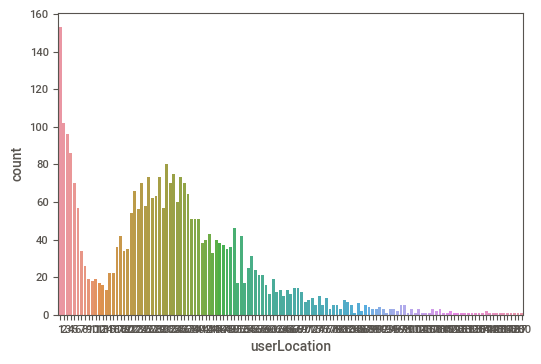

In [74]:
sns.countplot(df.groupby('publicationDate').userLocation.count());

In [ ]:
dados.groupby('userLocation').averageRating.count().plot()

In [ ]:
sns.countplot(dados.averageRating);

In [ ]:
sns.countplot(dados.ratingValue);

In [ ]:
sns.catplot(x="mobileDevice", kind="count", palette="ch:.25", data=dados)

### 4.Gráficos

####4.1  Avalições de estabelicimentos por Estados em ordem descrescente.

In [ ]:
df_Adressregion = df['AddressRegion'].value_counts().to_frame() # https://www.kaggle.com/parulpandey/five-ways-to-use-value-counts https://re-thought.com/pandas-value_counts/https://re-thought.com/pandas-value_counts/
df_Adressregion.head()

,AddressRegion
Estado de São Paulo,17455
Estado do Rio de Janeiro,10583
Rio Grande do Norte,7075
Ceará,6206
Bahia,6030


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 27 Text major ticklabel objects>)

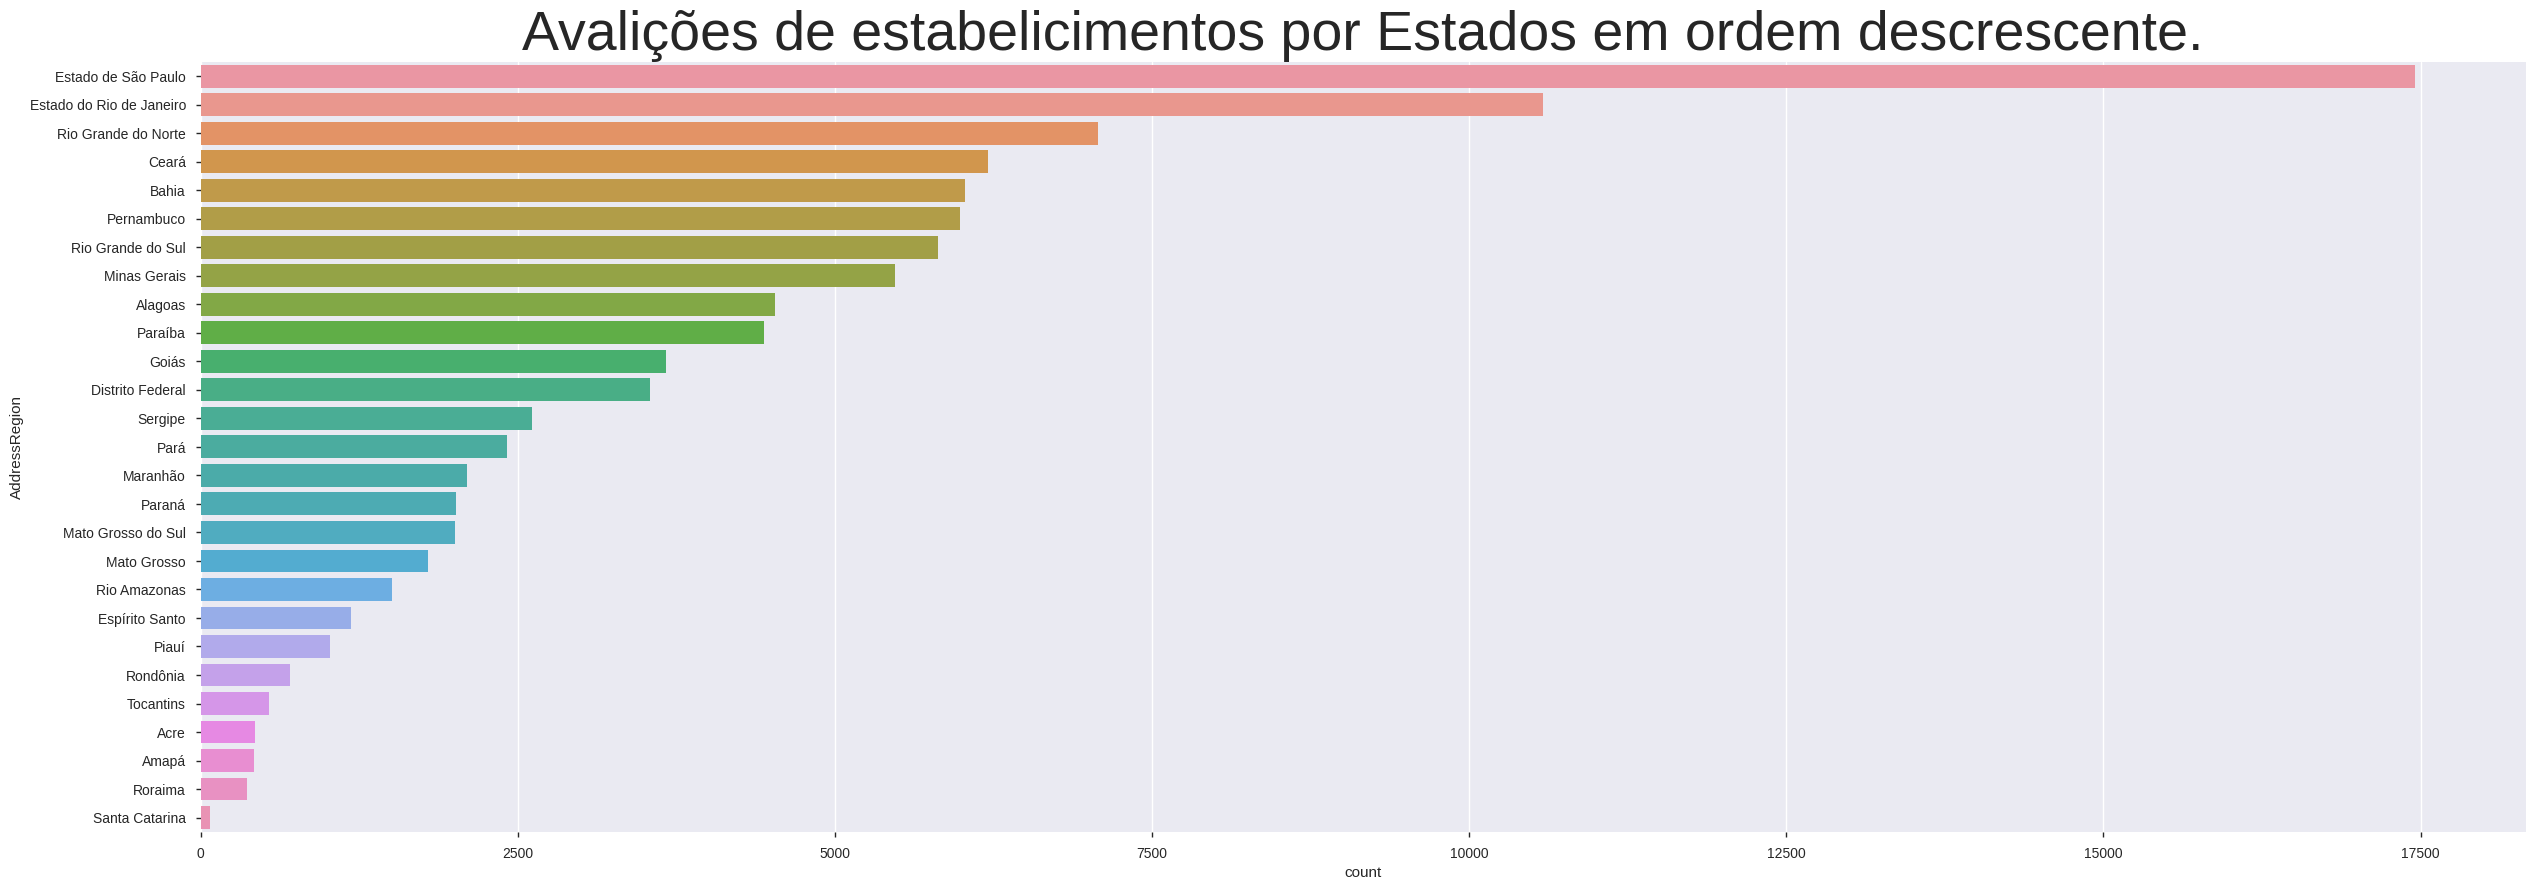

In [ ]:
#Gráfico de Estados com mais avalições em ordem descrescente. 
fig = plt.figure(figsize=(30,10)) 
sns.countplot(y='AddressRegion', order = df['AddressRegion'].value_counts().index, data=df)
plt.title('Avalições de estabelicimentos por Estados em ordem descrescente.',fontsize=40)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.ylim(0.1,30)

####4.2 Avaliações por tipo dispositivos

Text(0.5, 1.0, 'Percentual de avaliação por dispositivos')

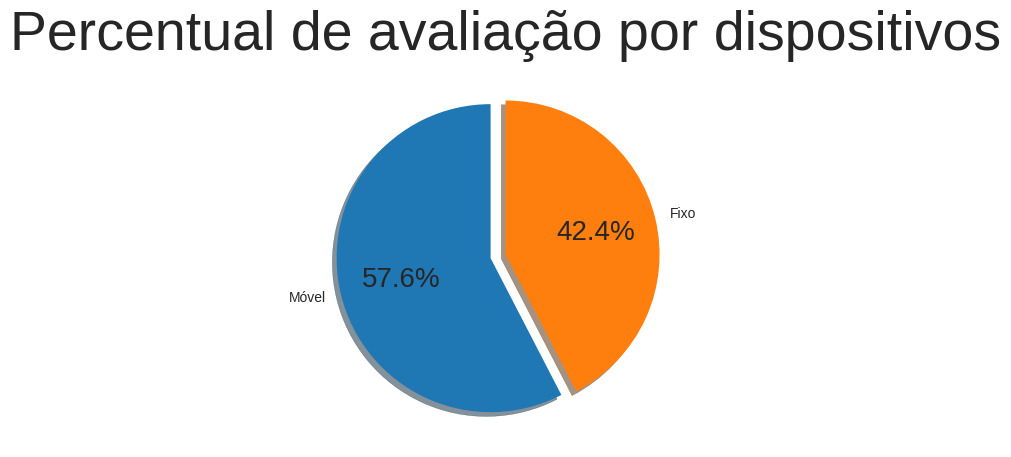

In [ ]:
# Percentual de avaliação por dispositivos - https://www.youtube.com/watch?v=wYxDyg1UnMw

plt.rcParams.update({'font.size':20})
rotulos = ['Móvel', 'Fixo']
dfdisp = df.groupby(by='mobileDevice').size()
explode = (0.1,0)
plt.figure(figsize=(5,5))
plt.pie(x=dfdisp, labels=rotulos,explode=explode, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Percentual de avaliação por dispositivos',fontsize=40)
##plt.show()

####4.3 Avalições de Estabelecimentos do Amazonas

In [ ]:
df_am = df[df['AddressRegion']=='Rio Amazonas'] 
df_am.head()
df_am2= df_am['Name'].value_counts().to_frame()
df_am2.head(10)

,Name
Banzeiro,209
Coco Bambu Manaus,154
Cachaçaria do Dedé e Empório - Manauara Shopping,118
Tambaqui de Banda - Parque 10,77
La Parrilla,74
Caxiri Manaus,57
Churrascaria Búfalo,49
Choupana,46
Bar Do Armando,37
Tacacá da Gisela,29


In [ ]:
df_am2.sum()

Name    1506
dtype: int64

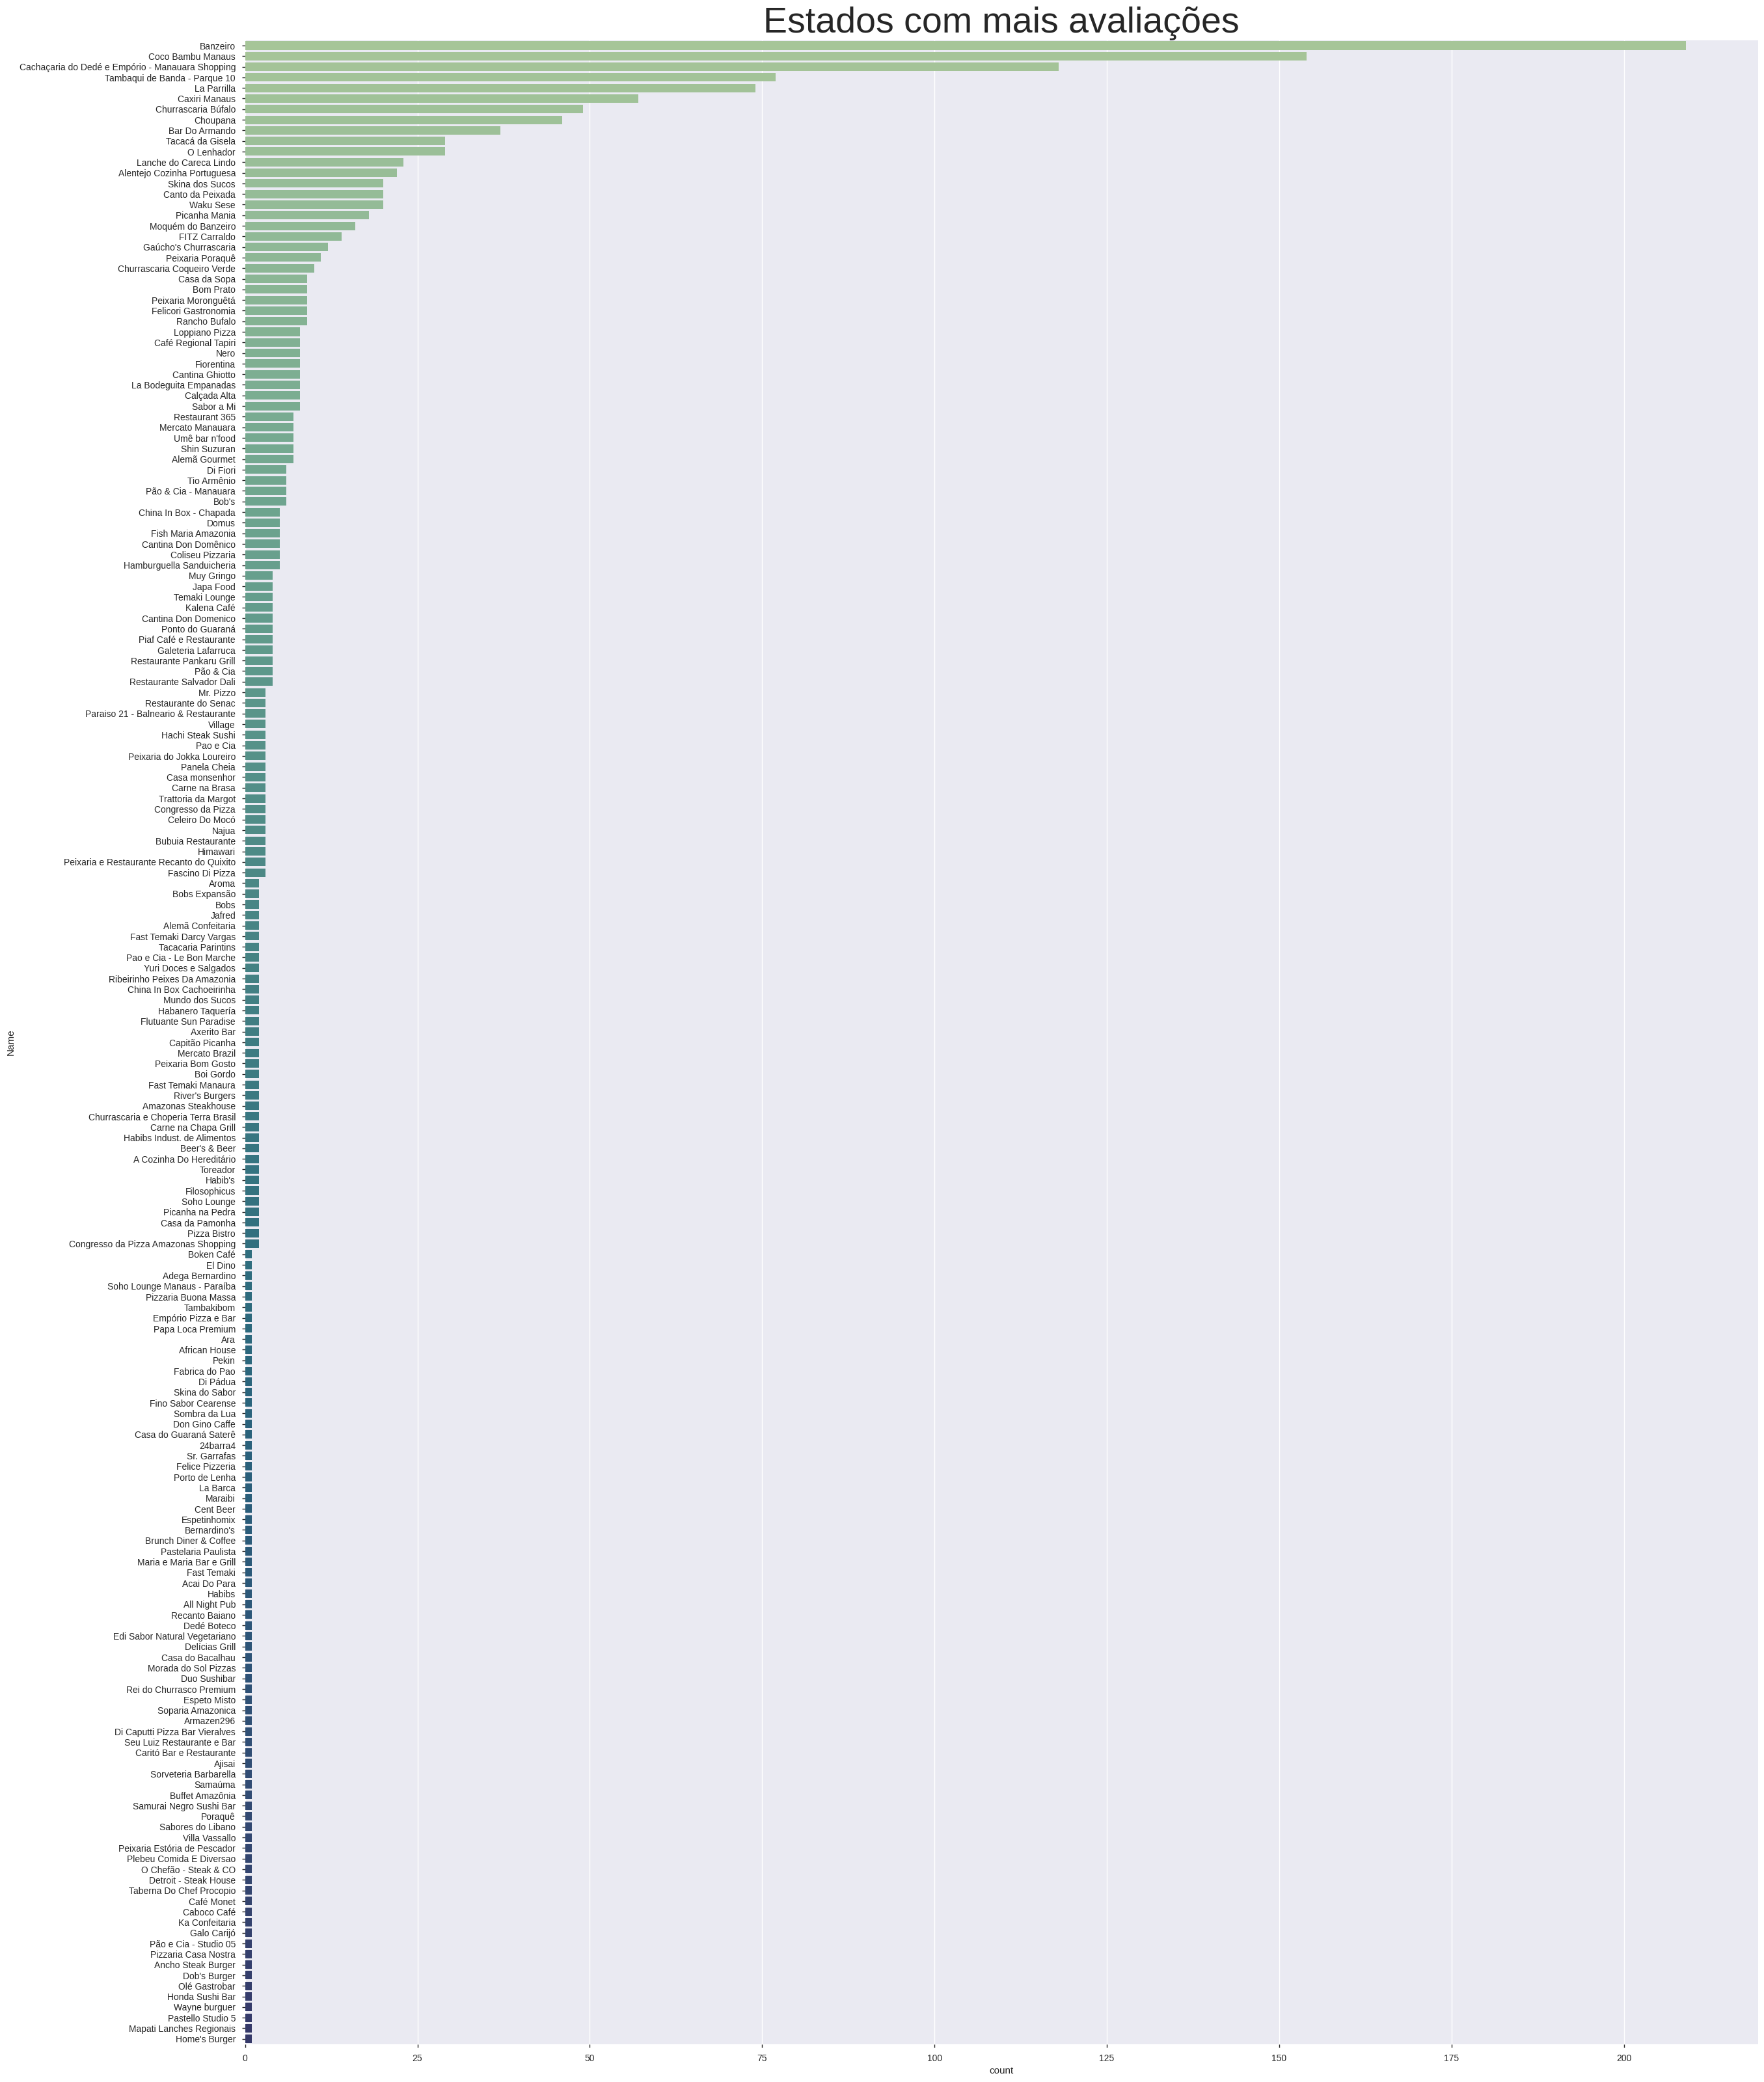

In [ ]:
fig = plt.figure(figsize=(30,40))
plt.title('Estados com mais avaliações',fontsize=40)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.countplot(y='Name', order = df_am['Name'].value_counts().index, data=df_am, palette='crest')

#### 4.4 Avaliações por Localização do Usuários

In [ ]:
# Divide o campo User Location com os valores após a , para uma nova coluna denominadas de Estado e Cidade, https://pt.linkedin.com/pulse/dividindo-colunas-por-delimitador-com-python-fernanda-santos
divisao = df['userLocation'].str.split(',') 
Cidade = divisao.str.get(0) 
Estado = divisao.str.get(1)
df['Cidade'] = Cidade.str.upper()
df['Estado'] = Estado.str.upper()
df.head()

,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,Name,StressAddress,AddressLocality,AddressRegion,PostalCode,Country,Website,Email,PhoneNumber,AverageRating,Cidade,Estado
0,Jantar,692856288,2344932,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,Imperador dos Camarões,Avenida Doutor Antônio Gouveia,,Alagoas,57030-170,Brasil,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5,SÃO CARLOS,SP
1,Uma boa experiência.,229208487,3720906,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,Guacamole Natal,Avenida Praia de Ponta Negra 9068 Ponta Negra,,Rio Grande do Norte,59092-100,Brasil,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5,MANAUS,AM
2,Otimo self service,679002332,2248105,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,Chica Pitanga,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5,GOIÂNIA,GO
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,Sorvetes Vi Sabor,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,,Brasil,None,None,None,4.0,ARACAJU,SE
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,Z Deli Sandwich Shop,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5,RIO DE JANEIRO,RJ


In [ ]:
df['nest']=len(df[('Estado')])

In [ ]:
df.dtypes

title               object
reviewId            object
restaurantId        object
author              object
reviewBody          object
language            object
mobileDevice        object
userLocation        object
publicationDate     object
visitDate           object
ratingValue         object
Name                object
StressAddress       object
AddressLocality     object
AddressRegion       object
PostalCode          object
Country             object
Website             object
Email               object
PhoneNumber         object
AverageRating      float64
Cidade              object
Estado              object
nest                 int64
dtype: object

In [ ]:
df_Estado = df['Estado'].value_counts().to_frame()[:20] # https://www.kaggle.com/parulpandey/five-ways-to-use-value-counts https://re-thought.com/pandas-value_counts/https://re-thought.com/pandas-value_counts/
df_Estado.head(10)

,Estado
SP,20673
RJ,9780
MG,6422
DF,5605
RS,5398
BA,4445
PE,4220
CE,3539
PR,3088
GO,2950


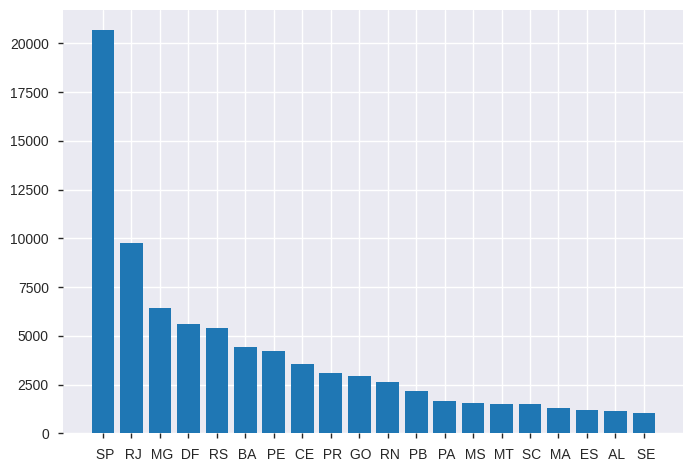

In [ ]:
plt.bar(df_Estado.index,df_Estado['Estado'])
plt.show()

#### 4.5 Avaliações por ano

In [ ]:
#Converter 	a coluna  publicationDate para data
df['publicationDate'] = pd.to_datetime(df['publicationDate'])
df.dtypes

title                      object
reviewId                   object
restaurantId               object
author                     object
reviewBody                 object
language                   object
mobileDevice               object
userLocation               object
publicationDate    datetime64[ns]
visitDate                  object
ratingValue                object
Name                       object
StressAddress              object
AddressLocality            object
AddressRegion              object
PostalCode                 object
Country                    object
Website                    object
Email                      object
PhoneNumber                object
AverageRating             float64
Cidade                     object
Estado                     object
nest                        int64
dtype: object

In [ ]:
ddt= df.groupby(df['publicationDate'].dt.year).size().reset_index().rename(columns={0: 'Total', 'publicationDate':'Date'})
ddt= f = ddt.rename(columns={'publicationDate':'Date'})
ddt.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11
Date,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Total,2,11,150,1322,5826,12713,17812,22056,14038,12549,11263,2258


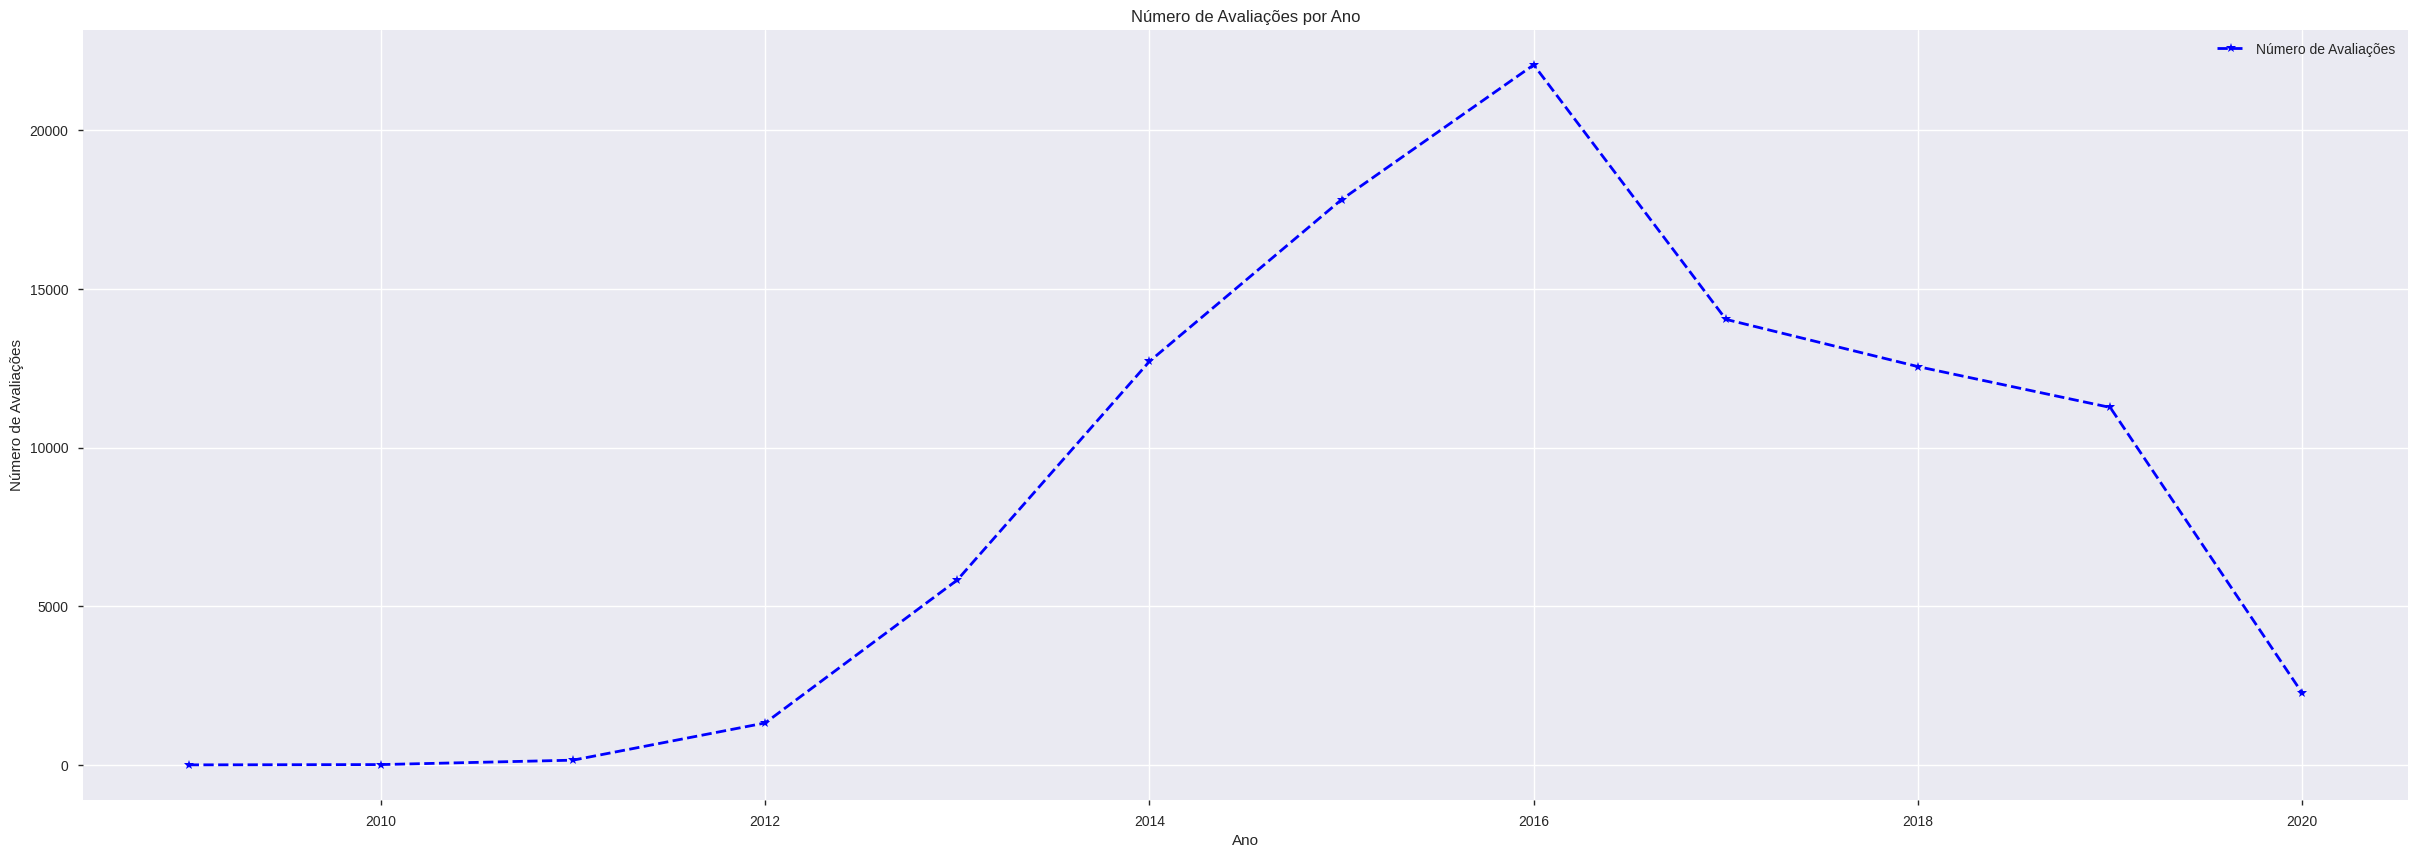

In [ ]:
x = ddt['Date']
y = ddt['Total']
plt.figure(figsize=(30,10))#tamanho do grafico
plt.plot(x,y,label='Número de Avaliações',color='blue',linestyle='--',linewidth=2,marker = "*")#plot para grafico de linhas 
#titulo
plt.title('Número de Avaliações por Ano')
#EIXO X
plt.xlabel('Ano')
#EIXO Y 
plt.ylabel('Número de Avaliações')
plt.grid(True)
plt.legend()

### **5. Analise dos Sentimentos** 

##Seleção do número aleatório de 200 sentenças

In [43]:
def twoHandSentences():
  import random as rd 
  rand = rd.randint(0,10000)
  check = 0
  arm = []
  for x in range(0,200):
    rand = rd.randint(0,10000)
    #print(f'{x} rand {rand}')
    arm.append(rand)
  return arm
_Sentences = twoHandSentences()
sizeFinal = len(_Sentences)

##Carregamento do itens selecionado aleatoriamente da base de dados

In [44]:
def arangeSentences(_Sentences):
  armSent = []
  x = 0
  for sent in _Sentences:
    init = json.loads(a[sent])
    dados = pd.json_normalize(init)
    armSent.append(dados)
  return armSent

sentencesWereSaved = arangeSentences(_Sentences)

In [49]:
arrange = pd.concat(objs=sentencesWereSaved, axis=0)

In [50]:
def clean_tripadvisor(tweet):
    try:
        tweet = BeautifulSoup(tweet, 'lxml').get_text() # o lxml indica o parse pode ser usado para dados de web por ex
        tweet = re.sub(r"\b\s-\s", ' ', tweet)
        tweet = re.sub(r"\s....", '', tweet)
        tweet = re.sub(r"\b\.\s\\n", '. \n', tweet)
        tweet = re.sub(r"\b\.", '. \n', tweet)    
        return tweet
    except TypeError:
        print("Errou o tipo no regex")

#Avaliação se Subjetiva ou factual

In [ ]:
def whichIsSentence(subj,pol):
  if subj == 0.0 and pol == 0.0:
    print("subjetiva")
  elif subj < 1.1 and pol == 1.1:
    print("positivo com alto indice subjetivo") 
  

##Métodos de avaliação: Precisão, Renovação e Medida-F

In [ ]:
def methodAvailable():
  pass

##Avaiable each sentence

In [53]:
inicio = 0
terminou = 2
var = 0
errou = 0
for x in arrange['reviewBody']:
    ini = time.time()
    var = var + 1
    if var > inicio and var <= terminou:
        print("**************\n")
        print( "var {} x {}".format(var,x))
        print("**************\n")
        out = clean_tripadvisor(x)
        #################################
        try:
            which = TextBlob(out)
            print("Tipo de which language: ",type(which))
            lang = which.detect_language()
            if lang == 'en':
                print("It is english")

                comentario_blob_pt = which.translate(to='pt')
                comentario_blob_us = comentario_blob_pt.translate(to='en'))
                print("Original em Inglês: ",which)
                print("Traduzido para Português: ",comentario_blob_pt)
                time.sleep(5)

                for sentence_br, sentence in zip(comentario_blob_pt.sentences, comentario_blob_us.sentences):
                   
                    if sentence_br is None:
                        errou = errou + 1
                        print("errou em {} - {} {}".format(var,errou,x))
                        #saveDocumentError(var,errou,x)

                    elif var > inicio and var <= terminou:
                        print('Polaridade\n',sentence_br, ':', sentence.sentiment.polarity)
                        print('subjetividade\n',sentence_br, ':', sentence.sentiment.subjectivity)
                        #saveDocument(var,sentence_br,sentence.sentiment.subjectivity,sentence.sentiment.polarity, 'fim')

                    else:
                        print("EN algum erro ocorreu em {}".format(var))
                ################################################

            elif lang == 'pt':
                print("It is portuguese")
                #################################
                comentario_blob = TextBlob(out)
                print("comentario_blob ",type(comentario_blob))

                comentario_blob_us = comentario_blob.translate(to='us')
                print("tipo em english ", type(comentario_blob_us))
                print("Inglês: ",comentario_blob_us)
                time.sleep(5)

                for sentence_br, sentence in zip(comentario_blob.sentences, comentario_blob_us.sentences):
                
                    if sentence_br is None:
                        errou = errou + 1
                        print("errou em {} - {} {}".format(var,errou,x))
                        #saveDocumentError(var,errou,x)

                    elif var > inicio and var <= terminou:
                        print('Polaridade\n',sentence_br, ':', sentence.sentiment.polarity)
                        print('subjetividade\n',sentence_br, ':', sentence.sentiment.subjectivity)
                        #saveDocument(var,sentence_br,sentence.sentiment.subjectivity,sentence.sentiment.polarity, 'fim')

                    else:
                        print("PT algum erro ocorreu em {}".format(var))
                ################################################
            else:
                print("Not english")
        except TypeError:
            print("Errou não é tipo string")
            continue
        
    if var == terminou:
        print("Finalizou em ",var)
        break
    fim = time.time()
    print("tempo final foi ", ini-fim)
   

**************

var 1 x Comida excelente! Cheiro de roça, ambientação "lá de Minas sô". O "Chefe da Casa", Geraldinho, tem uma memória de elefante: mesmo depois de meses sem me ver, me chama pelo nome; a sócia e esposa brinca com as crianças com simpatia. Geraldinho te leva ao forno e mostra como tudo é feito. Os quitutes (leia-se, aqueles fazem agente pensar na glicose!) são inquestionáveis. Não deixe de comer o carneiro e a galinha à cerveja.
**************

Tipo de which language:  <class 'textblob.blob.TextBlob'>


HTTPError: ignored